# Análise geográfica

Este notebook terá foco na análise por cidade/região.

In [ ]:
# carregando a base
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_csv('/home/l-tiezerin/mentoria_dados/data_tables/starting_df.csv')
df.head()

,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,9,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,IS NULL,IS NULL
1,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,9,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,IS NULL,IS NULL
2,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,4,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,13,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [ ]:
# verificando a quantidade de cidades diferentes constando na base
df['City'].nunique()

1106

São muitas cidades diferentes para se analisar (1.106). Há concentração de clientes em alguma?

In [ ]:
# verificando a proporção de clientes por cidade
df['City'].value_counts(normalize=True)*100

City
Los Angeles         4.160159
San Diego           4.046571
San Jose            1.590231
Sacramento          1.533437
San Francisco       1.476643
                      ...   
Eldridge            0.028397
Holtville           0.028397
Johannesburg        0.028397
South Lake Tahoe    0.028397
Jacumba             0.028397
Name: proportion, Length: 1106, dtype: float64

De cara é possível notar uma dispersão muito grande. A partir da terceira cidade em diante, a concentyração fica em torno de 1%. As coordenadas podem ajudar a evidenciar possíveis concentrações em regiões específicas?

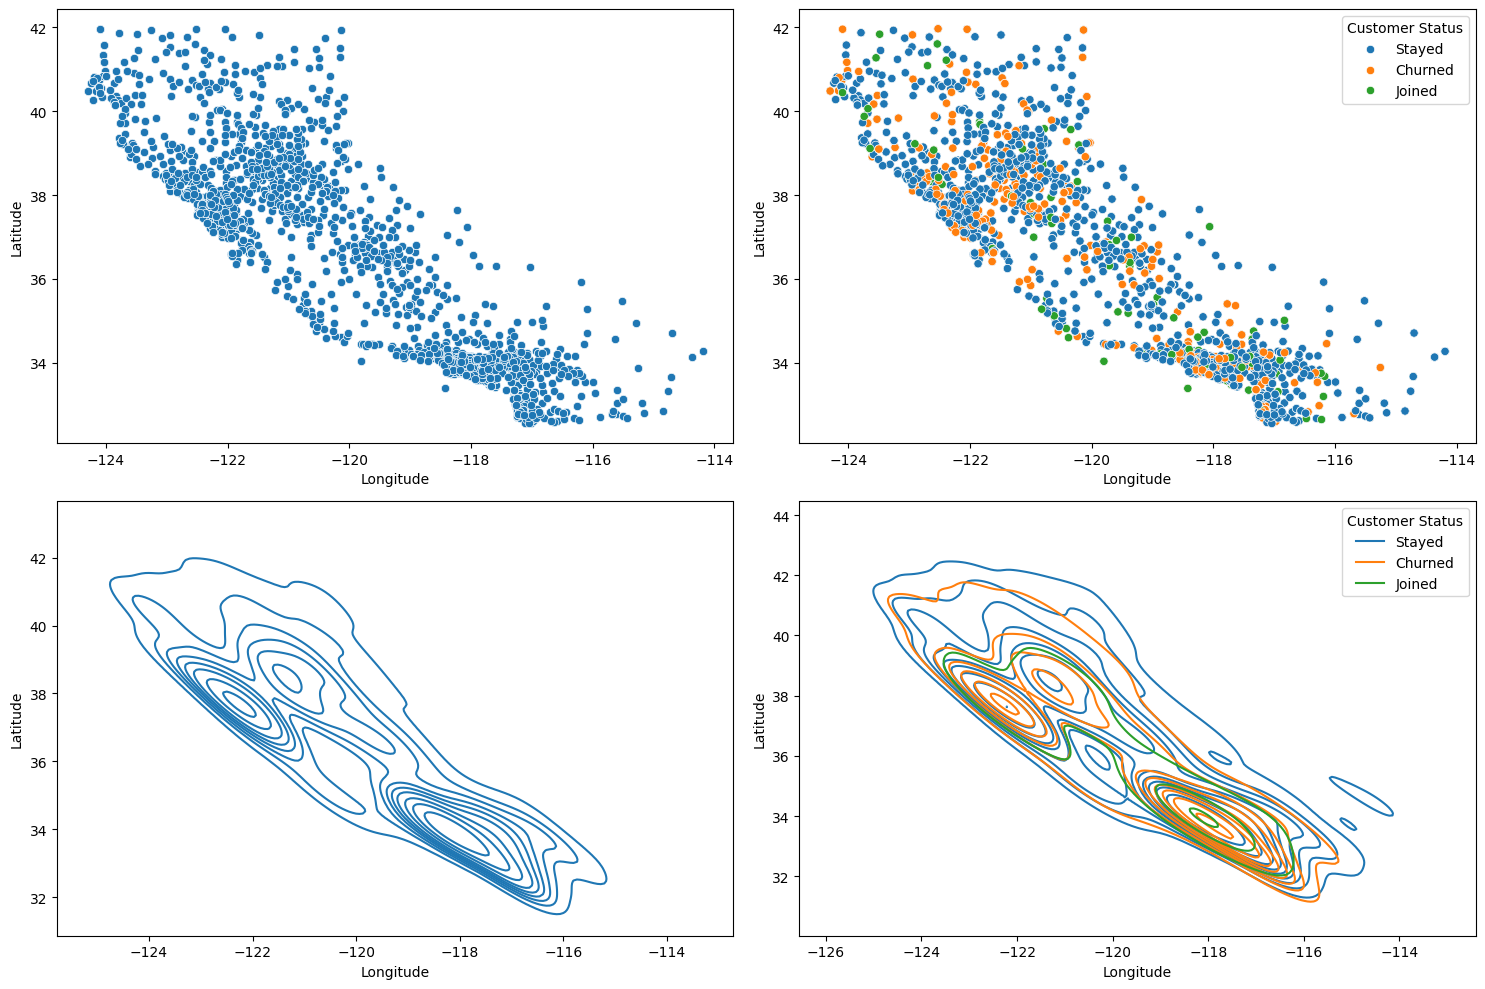

In [ ]:
# visualizando clientes e status geograficamente
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), tight_layout=True)
axs = axs.flatten()

sns.scatterplot(data=df, x='Longitude', y='Latitude', ax=axs[0])
sns.scatterplot(data=df, x='Longitude', y='Latitude', hue='Customer Status', ax=axs[1])

sns.kdeplot(data=df, x='Longitude', y='Latitude', ax=axs[2])
sns.kdeplot(data=df, x='Longitude', y='Latitude', hue='Customer Status', ax=axs[3])

plt.show()

Há pelo menos três regiões, onde se formam os círculos, que podem ser analisadas com mais atenção. Em relação ao status do cliente, será melhor de visualizar se separarmos os gráficos por status e comparar os formatos. 

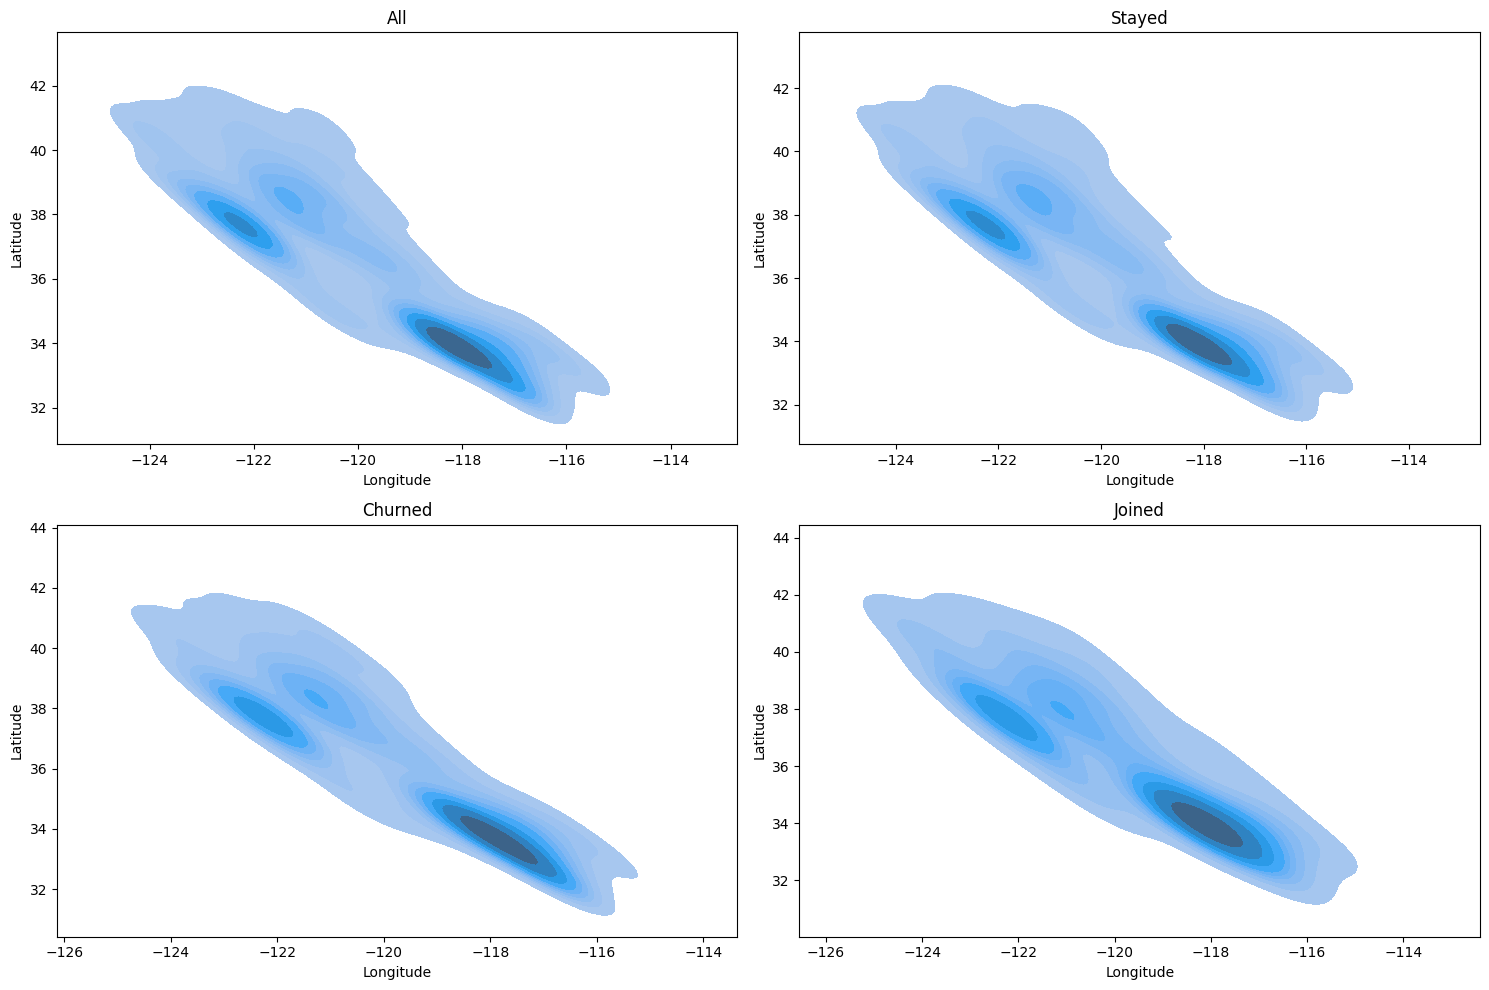

In [ ]:
# comparando a distribuição de clientes por status com o geral
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), tight_layout=True)
axs = axs.flatten()

for i, status in enumerate(['All', *df['Customer Status'].unique()]):
    if i == 0:
        sns.kdeplot(data=df, x='Longitude', y='Latitude', ax=axs[i], fill=True, linewidth=0)
    else:
        sns.kdeplot(data=df[df['Customer Status']==status], x='Longitude', y='Latitude', ax=axs[i], fill=True, linewidth=0)

    axs[i].set_title(status)

plt.show()

Todos os status tem formatos semelhantes na distribuição geográfica (dois focos em maior latitude e um em maior longitude). Apenas com base nisso, não há diferença significativa. Mas haveria diferenças em relação à razão do churn?